In [1]:
import xarray as xr
import metpy
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
from metpy.units import units
from datetime import datetime
import numpy as np
#import sharppy.plot.skew as spskew
from plots import plot_skewt
from siphon.catalog import TDSCatalog
from xarray.backends import NetCDF4DataStore
from geopy.geocoders import Nominatim
import cdsapi
from urllib.request import urlopen
import reanalysis_requests

In [2]:
lon_grid, lat_grid, p_skew, hgt_agl, T_skew, Td_skew, u_skew, v_skew, time, reanalysis = reanalysis_requests.sel_data(reanalysis='ERA5', cidade='Muitos Capões', estado='RS', dt = '2005082918')

/home/viper/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1423: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


0.0 1539.50634765625


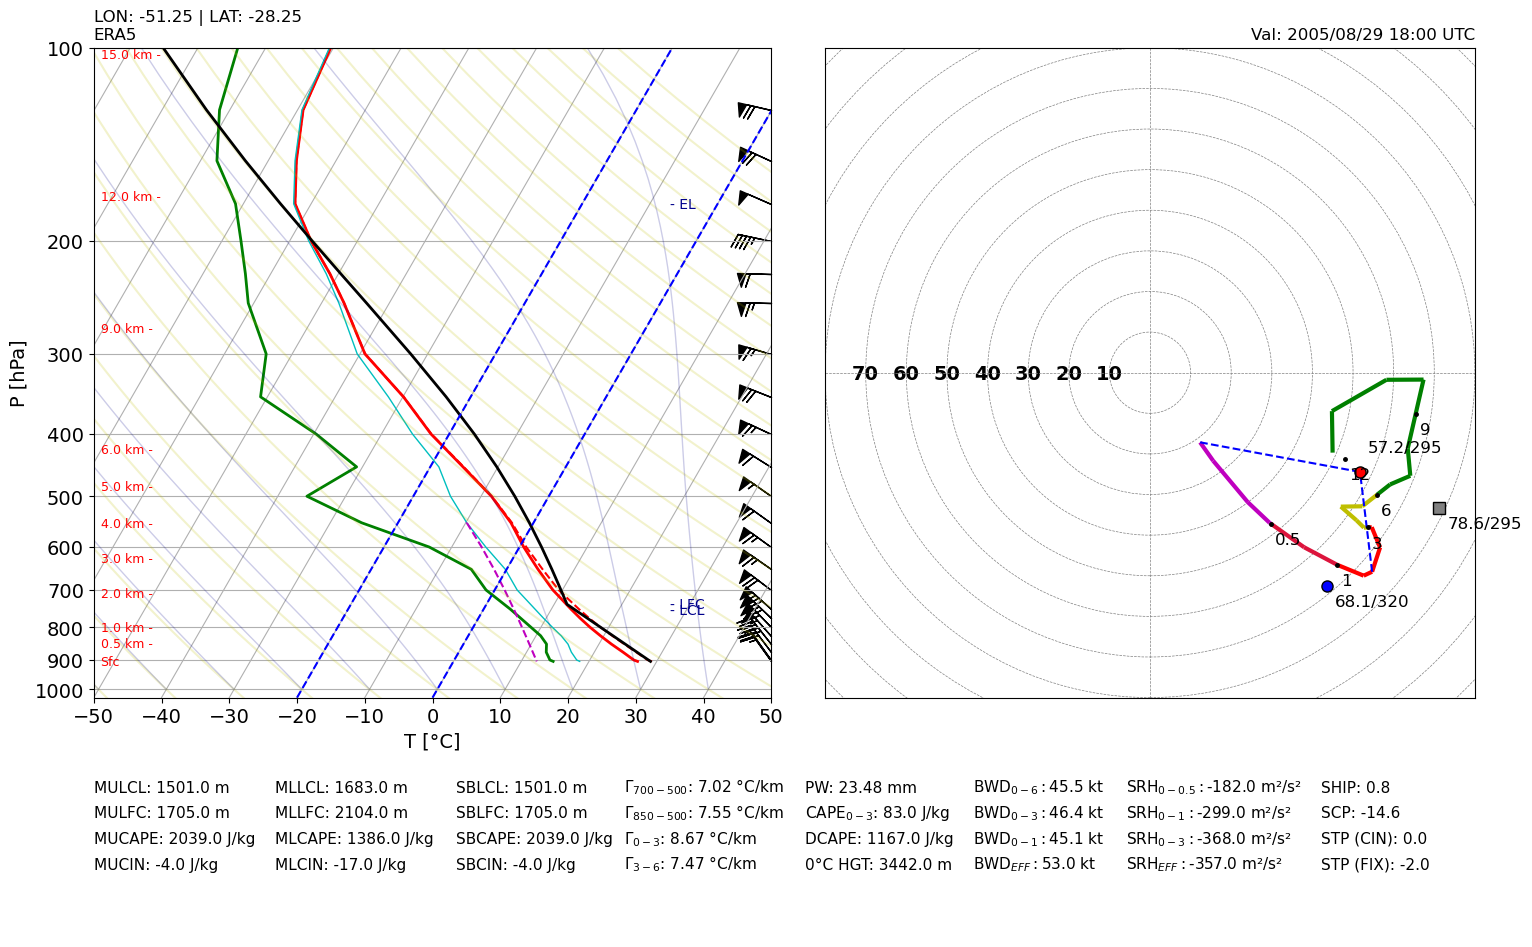

In [3]:
prof, fig = plot_skewt(lon_grid = lon_grid, lat_grid = lat_grid, pressure = p_skew.magnitude, hgt_agl = hgt_agl.magnitude, tmp = T_skew, td = Td_skew,
                       u_wind = u_skew, v_wind = v_skew, val_time = f'{time:%Y/%m/%d %H:%M}', reanalysis=reanalysis, parcel_to_draw = 'ml')
    
plt.savefig('/mnt/c/Users/User/Desktop/' + 'aaa' + '.jpg', bbox_inches = 'tight', dpi = 300)

In [3]:
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
import numpy as np
from datetime import datetime
from metpy.units import units
import metpy.calc as mpcalc
import glob, os
from sharppy.sharptab import winds, utils, params, thermo, interp, profile
import sharppy.plot.skew as skew
import matplotlib as mpl
from matplotlib.patches import Circle
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter, MultipleLocator, NullFormatter
from matplotlib.collections import LineCollection
import matplotlib.transforms as transforms
from matplotlib.collections import PatchCollection
from metpy.plots import Hodograph
import skewx

def plot_skewt(pressure, hgt_agl, tmp, td, u_wind, v_wind, leftmover = True, save_dir = None, parcel_to_draw = 'mu',
               lat_grid = None, lon_grid = None, init_time = None, val_time = None, hgt_0c = None, reanalysis = 'ERA5'):
    
    prof = profile.create_profile(pres = pressure, hght = hgt_agl, tmpc = tmp, dwpc = td, u = u_wind, v = v_wind, profile = 'default')

    #evaluate important thermodynamic and shear parameters
    sfc_pcl = params.parcelx(prof, flag = 1)
    ml_pcl = params.parcelx(prof, flag = 4)
    mu_pcl = params.parcelx(prof, flag = 3)
    
    dcape, d_trace, d_ptrace = params.dcape(prof)
    cape_03 = np.round(sfc_pcl.b3km)
    pw = np.round(params.precip_water(prof) * 25.4, 2)

    mulcl = np.round(mu_pcl.lclhght)
    mulfc = np.round(mu_pcl.lfchght)
    mucape = np.round(mu_pcl.bplus)
    mucin = np.round(mu_pcl.bminus)

    mllcl = np.round(ml_pcl.lclhght)
    mllfc = np.round(ml_pcl.lfchght)
    mlcape = np.round(ml_pcl.bplus)
    mlcin = np.round(ml_pcl.bminus)

    sblcl = np.round(sfc_pcl.lclhght)
    sblfc = np.round(sfc_pcl.lfchght)
    sbcape = np.round(sfc_pcl.bplus)
    sbcin = np.round(sfc_pcl.bminus)

    lr_700_500 = np.round(params.lapse_rate(prof, 750, 500), 2)
    lr_850_500 = np.round(params.lapse_rate(prof, 850, 500), 2)
    lr_0_3 = np.round(params.lapse_rate(prof, 0, 3000, pres = False), 2)
    lr_3_6 = np.round(params.lapse_rate(prof, 3000, 6000, pres = False), 2)
    p0c = params.temp_lvl(prof, 0)
    h0c = np.round(interp.hght(prof, p0c))

    P_sfc = prof.pres[prof.sfc]
    mu_el = mu_pcl.elpres * 0.65
    p_6 = interp.pres(prof, interp.to_msl(prof, 6000))
    p_3 = interp.pres(prof, interp.to_msl(prof, 3000))
    p_1 = interp.pres(prof, interp.to_msl(prof, 1000))
    in_pres = [interp.pres(prof, interp.to_agl(prof, h)) for h in [500, 1000, 3000, 6000, 9000, 12000]]
    in_wind = [interp.components(prof, p) for p in in_pres]
        
    eff_inflow = params.effective_inflow_layer_binary(prof=prof, mupcl=mu_pcl)
    eff_bot_m = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
    eff_top_m = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
    eff_wind = [interp.components(prof, p) for p in [eff_inflow[0], eff_inflow[1]]]
    
    print(eff_bot_m, eff_top_m)
        
    bwd06 = np.round(winds.wind_shear(prof, P_sfc, p_6), 1)
    bwd06_mag = np.round(utils.mag(bwd06[0], bwd06[1]), 1)
    bwd03 = np.round(winds.wind_shear(prof, P_sfc, p_3), 1)
    bwd03_mag = np.round(utils.mag(bwd03[0], bwd03[1]), 1)
    bwd01 = np.round(winds.wind_shear(prof, P_sfc, p_1), 1)
    bwd01_mag = np.round(utils.mag(bwd01[0], bwd01[1]), 1)

    ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
    eff_bwd = np.round(utils.mag(ebwd[0], ebwd[1]), 1)
        
    rstu, rstv, lstu, lstv = winds.non_parcel_bunkers_motion(prof)
    mwind = winds.mean_wind(prof, eff_inflow[0], mu_el, lstu, lstv)
    rst_dir, rst_wsp = np.round(utils.comp2vec(rstu , rstv), 1)
    lst_dir, lst_wsp = np.round(utils.comp2vec(lstu , lstv), 1)
    mwind_dir, mwind_wsp = np.round(utils.comp2vec(mwind[0], mwind[1]), 1)
        
    ship = np.round(params.ship(prof), 1)

    if leftmover is True:
        srh0_500, _, _ = np.round(winds.helicity(prof, 0, 500, lstu, lstv))
        srh0_1000, _, _ = np.round(winds.helicity(prof, 0, 1000, lstu, lstv))
        srh0_3000, _, _ = np.round(winds.helicity(prof, 0, 3000, lstu, lstv))
        stp_fix = np.round(params.stp_fixed(sbcape, sblcl, srh0_1000, bwd06_mag), 1)
        srh_eff = np.round(winds.helicity(prof, eff_bot_m, eff_top_m, lstu, lstv))[0]
        scp = np.round(params.scp(mucape, srh_eff, eff_bwd), 1)
        stp_cin = np.round(params.stp_cin(mlcape, srh_eff, eff_bwd, mllcl, mlcin), 1)
    
    else:
        srh0_500, _, _ = np.round(winds.helicity(prof, 0, 500, rstu, rstv))
        srh0_1000, _, _ = np.round(winds.helicity(prof, 0, 1000, rstu, rstv))
        srh0_3000, _, _ = np.round(winds.helicity(prof, 0, 3000, rstu, rstv))
        stp_fix = np.round(params.stp_fixed(sbcape, sblcl, srh0_1000, bwd06_mag), 1)
        srh_eff = np.round(winds.helicity(prof, eff_bot_m, eff_top_m, rstu, rstv))[0]
        scp = np.round(params.scp(mucape, srh_eff, eff_bwd), 1)
        stp_cin = np.round(params.stp_cin(mlcape, srh_eff, eff_bwd, mllcl, mlcin), 1)
    
    #plot our skewT logP diagram
    fig = plt.figure(figsize=(18, 16))
    gs = gridspec.GridSpec(6, 6)
    ax = plt.subplot(gs[:3, :3], projection = 'skewx')

    ax.semilogy(prof.tmpc[~prof.tmpc.mask], prof.pres[~prof.tmpc.mask], 'r', lw=2)
    ax.semilogy(prof.dwpc[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'g', lw=2)
    Tv_line = ax.semilogy(prof.vtmp[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'r--')
    ax.semilogy(prof.wetbulb[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'c-', lw = 1)
    ax.semilogy(d_trace, d_ptrace, 'm--')
    ax.grid(True)

    skew.draw_dry_adiabats(ax, tmin = -70, alpha = 0.2, color = 'y')
    skew.draw_moist_adiabats(ax, tmin = -70, alpha = 0.2, color = 'darkblue')
    skew.draw_heights(ax, prof)
    skew.plot_sig_levels(ax, mu_pcl)
    skew.plot_wind_barbs(ax, prof.pres, prof.u, prof.v)
        
    try:
        skew.draw_effective_inflow_layer(ax, prof)
    except:
        print("Couldn't plot effective inflow layer ...")

    # Plot the parcel trace, but this may fail.  If it does so, inform the user.
    try:
        if parcel_to_draw == 'ml':
            parcel_line = ax.semilogy(ml_pcl.ttrace, ml_pcl.ptrace, 'k', lw = 2)
        if parcel_to_draw == 'sb':
            parcel_line = ax.semilogy(sfc_pcl.ttrace, sfc_pcl.ptrace, 'k', lw = 2)
        if parcel_to_draw == 'mu':
            parcel_line = ax.semilogy(mu_pcl.ttrace, mu_pcl.ptrace, 'k', lw = 2)
    except:
        print("Couldn't plot parcel traces ...")

    # Highlight the 0 C and -20 C isotherms.
    [ax.axvline(T_hgz, color='b', ls='--') for T_hgz in [-20, 0]]

    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_yticks(np.linspace(100, 1000, 10))
    ax.set_ylim(1030, 100)
    ax.set_yticks(np.linspace(100, 1000, 10))
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.set_xlim(-50, 50)
    ax.tick_params(labelsize = 14)
    ax.set_xlabel('T [°C]', fontsize = 14)
    ax.set_ylabel('P [hPa]', fontsize = 14)
    
    plt.title(f'LON: {np.round(lon_grid, 2)}, LAT: {np.round(lat_grid, 2)}' + '\n' + reanalysis, loc = 'left')
    
    mask = np.array(prof.hght) * units.m <= 12000 * units.m
    #plot the hodograph
    ax2 = plt.subplot(gs[:3, 3:])
    hodo = Hodograph(ax2)
    hodo.add_grid(linewidth = 0.5)
    hodo.plot_colormapped((np.array(prof.u)*units('kt'))[mask], (np.array(prof.v)*units('kt'))[mask], (np.array(prof.hght)*units('m'))[mask],
                          colors = ['m', 'crimson', 'r', 'y', 'g'], intervals = [0, 500, 1000, 3000, 6000, 12000] * units.m)

    #ax2.set_xlim(-80, 80)
    #ax2.set_ylim(-80, 80)
    ax2.plot([eff_wind[0][0], lstu], [eff_wind[0][1], lstv], color = 'blue', linestyle = '--')
    ax2.plot([eff_wind[1][0], lstu], [eff_wind[1][1], lstv], color = 'blue', linestyle = '--')
    ax2.plot(lstu, lstv, marker = 'o', markersize = 8, markerfacecolor = 'red', markeredgecolor = 'black')
    ax2.plot(rstu, rstv, marker = 'o', markersize = 8, markerfacecolor = 'blue', markeredgecolor = 'black')
    ax2.annotate(f'{rst_wsp}/{int(rst_dir)}',
                 xy=(rstu, rstv), xytext = (rstu + 2, rstv - 5), fontsize = 12)
    ax2.annotate(f'{lst_wsp}/{int(lst_dir)}',
                 xy=(lstu, lstv), xytext = (lstu + 2, lstv + 5), fontsize = 12)
    try:
        ax2.annotate(f'{mwind_wsp}/{int(mwind_dir)}',
                    xy=(mwind[0], mwind[1]), xytext = (mwind[0] + 2, mwind[1] - 5), fontsize = 12)
        ax2.plot(mwind[0], mwind[1], marker = 's', markersize = 8, color = 'gray', markeredgecolor = 'black')
    except:
        pass
        
    for w, l in zip(in_wind, ['0.5', '1', '3', '6', '9', '12']):
        ax2.plot(w[0], w[1], marker = 'o', markersize = 2.5, color = 'black')
        ax2.annotate(f'{l}', xy=(w[0], w[1]), xytext = (w[0] + 1, w[1] - 5), fontsize = 12)
    ax2.tick_params(axis = 'both', direction = 'in', left = False, bottom = False, pad = -240, labelleft = False, labelsize = 12)
    ax2.set_xticks(np.arange(-70, 0, 10))
    ax2.set_xticklabels(np.arange(70, 0, -10), fontweight = 'semibold', fontsize = 14)


    plt.title(f'Val: {val_time} UTC', loc = 'right')

    #plot the thermodynamic and shear variables
    ax3 = plt.subplot(gs[3, :])
    ax3.axis('off')
    ax3.tick_params(which = 'both', bottom = False, left = False, labelbottom = False, labelleft = False)

    ax3.text(0.0, 0.85, f'MULCL: {mulcl} m', fontsize = 11)
    ax3.text(0.0, 0.7, f'MULFC: {mulfc} m', fontsize = 11)
    ax3.text(0.0, 0.55, f'MUCAPE: {mucape} J/kg', fontsize = 11)
    ax3.text(0.0, 0.4, f'MUCIN: {mucin} J/kg', fontsize = 11)

    ax3.text(0.13, 0.85, f'MLLCL: {mllcl} m', fontsize = 11)
    ax3.text(0.13, 0.7, f'MLLFC: {mllfc} m', fontsize = 11)
    ax3.text(0.13, 0.55, f'MLCAPE: {mlcape} J/kg', fontsize = 11)
    ax3.text(0.13, 0.4, f'MLCIN: {mlcin} J/kg', fontsize = 11)

    ax3.text(0.26, 0.85, f'SBLCL: {sblcl} m', fontsize = 11)
    ax3.text(0.26, 0.7, f'SBLFC: {sblfc} m', fontsize = 11)
    ax3.text(0.26, 0.55, f'SBCAPE: {sbcape} J/kg', fontsize = 11)
    ax3.text(0.26, 0.4, f'SBCIN: {sbcin} J/kg', fontsize = 11)
        
    ax3.text(0.38, 0.85, r'$\Gamma_{700-500}$:' + f' {lr_700_500} °C/km', fontsize = 11)
    ax3.text(0.38, 0.7, r'$\Gamma_{850-500}$:' + f' {lr_850_500} °C/km', fontsize = 11)
    ax3.text(0.38, 0.55, r'$\Gamma_{0-3}$:' + f' {lr_0_3} °C/km', fontsize = 11)
    ax3.text(0.38, 0.4, r'$\Gamma_{3-6}$:' + f' {lr_3_6} °C/km', fontsize = 11)

    ax3.text(0.51, 0.85, f'PW: {pw} mm', fontsize = 11)
    ax3.text(0.51, 0.7, r'CAPE$_{0-3}$:' + f' {cape_03} J/kg', fontsize = 11)
    ax3.text(0.51, 0.55, f'DCAPE: {np.round(dcape)} J/kg', fontsize = 11)
    ax3.text(0.51, 0.4, f'0°C HGT: {h0c} m', fontsize = 11)

    ax3.text(0.63, 0.85, r'BWD$_{0-6}:$' + f'{bwd06_mag} kt', fontsize = 11)
    ax3.text(0.63, 0.7, r'BWD$_{0-3}:$' + f'{bwd03_mag} kt', fontsize = 11)
    ax3.text(0.63, 0.55, r'BWD$_{0-1}:$' + f'{bwd01_mag} kt', fontsize = 11)
    ax3.text(0.63, 0.4, r'BWD$_{EFF}:$' + f'{eff_bwd} kt', fontsize = 11)

    ax3.text(0.74, 0.85, r'SRH$_{0-0.5}:$' + f'{srh0_500} m²/s²', fontsize = 11)
    ax3.text(0.74, 0.7, r'SRH$_{0-1}:$' + f'{srh0_1000} m²/s²', fontsize = 11)
    ax3.text(0.74, 0.55, r'SRH$_{0-3}:$' + f'{srh0_3000} m²/s²', fontsize = 11)
    ax3.text(0.74, 0.4, r'SRH$_{EFF}:$' + f'{srh_eff} m²/s²', fontsize = 11)

    ax3.text(0.88, 0.85, f'SHIP: {ship}', fontsize = 11)
    ax3.text(0.88, 0.7, f'SCP: {scp}', fontsize = 11)
    ax3.text(0.88, 0.55, f'STP (CIN): {stp_cin}', fontsize = 11)
    ax3.text(0.88, 0.4, f'STP (FIX): {stp_fix}', fontsize = 11)
    
    gs.update(bottom = .025, hspace = 0.4, wspace = 0.2)

    #save or return our plot
    if save_dir is None:
        return prof, fig
    else:    
        plt.savefig(save_dir + f'{vtime_save}.jpg', bbox_inches = 'tight', dpi = 300)
        fig.clf()

/home/viper/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1423: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
/home/viper/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


-- --
Couldn't plot effective inflow layer ...


/home/viper/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


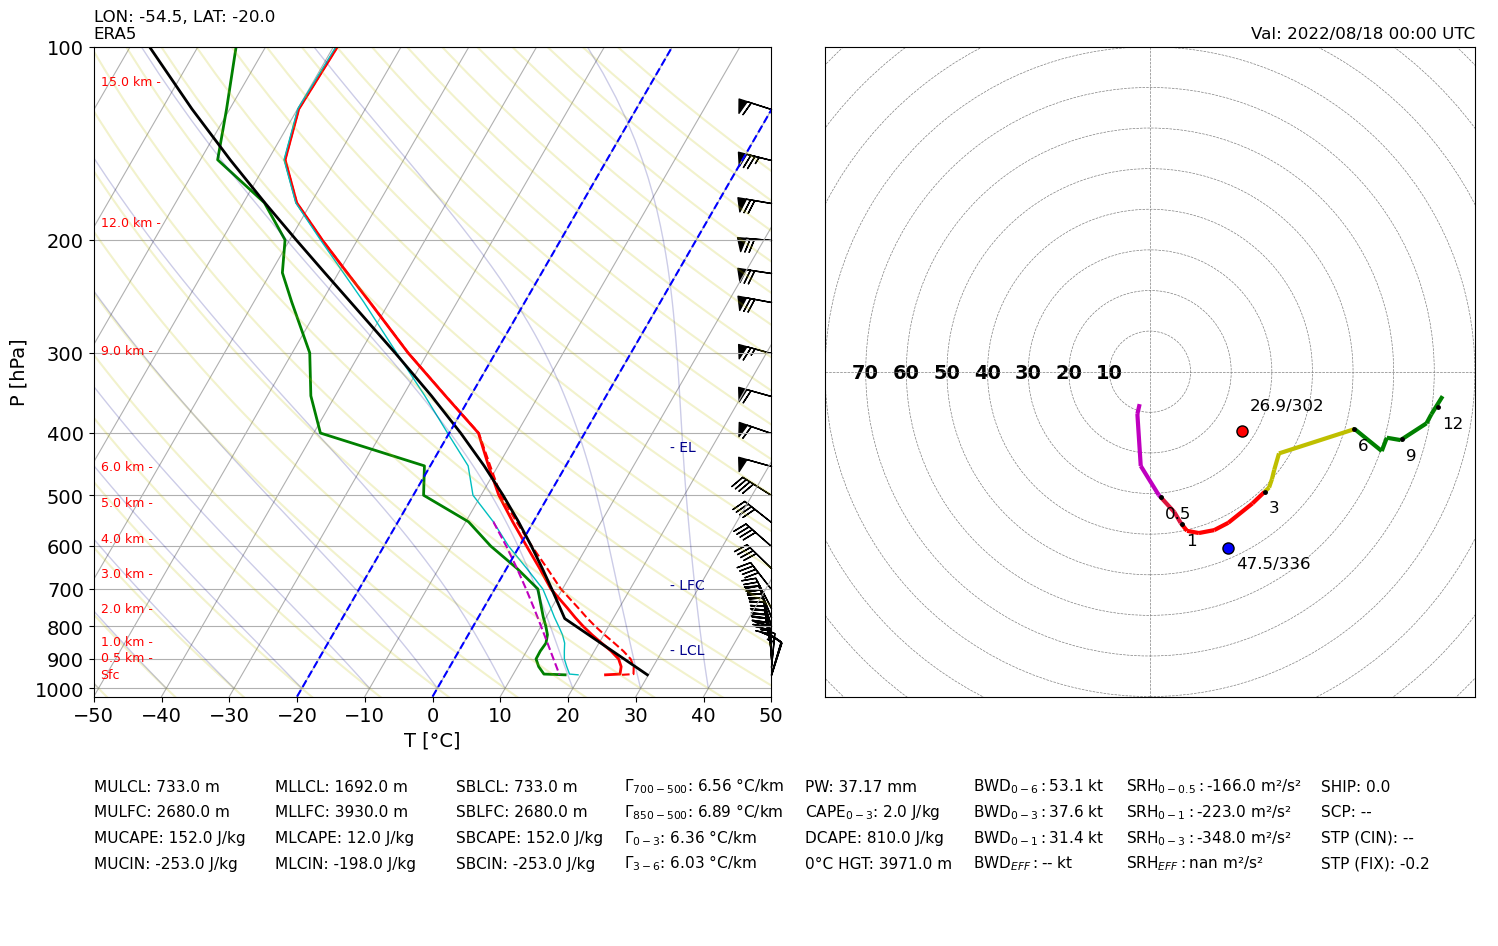

In [9]:
prof, fig = plot_skewt(lon_grid = lon_grid, lat_grid = lat_grid, pressure = p_skew.magnitude, hgt_agl = hgt_agl.magnitude, tmp = T_skew, td = Td_skew,
                       u_wind = u_skew, v_wind = v_skew, parcel_to_draw='ml', val_time = f'{time:%Y/%m/%d %H:%M}')

In [8]:
utils.MS2KTS()

masked_array(data=[952.5813598632812, 950.0, 925.0, 900.0, 875.0, 850.0,
                   825.0, 800.0, 775.0, 750.0, 700.0, 650.0, 600.0, 550.0,
                   500.0, 450.0, 400.0, 350.0, 300.0, 250.0, 225.0, 200.0,
                   175.0, 150.0, 125.0, 100.0, 70.0, 50.0, 30.0, 20.0,
                   10.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value=1e+20)